<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/EEG%20DFA%20investigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare dependencies

In [41]:
!pip install mne==1.1 --quiet

In [7]:
import mne

In [8]:
!pip install pyedflib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 14.9 MB/s eta 0:00:00


In [9]:
import pyedflib
from pyedflib import highlevel

In [82]:
#!wget https://github.com/TAUforPython/BioMedAI/raw/refs/heads/main/test_datasets/EDF_example_FS_healthy.edf
!wget https://github.com/TAUforPython/BioMedAI/raw/refs/heads/main/test_datasets/EEG_example_FS_patient.edf

--2024-11-11 15:44:53--  https://github.com/TAUforPython/BioMedAI/raw/refs/heads/main/test_datasets/EEG_example_FS_patient.edf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TAUforPython/BioMedAI/refs/heads/main/test_datasets/EEG_example_FS_patient.edf [following]
--2024-11-11 15:44:53--  https://raw.githubusercontent.com/TAUforPython/BioMedAI/refs/heads/main/test_datasets/EEG_example_FS_patient.edf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1007872 (984K) [application/octet-stream]
Saving to: ‘EEG_example_FS_patient.edf’

EEG_example_FS_pati 100%[===================>] 984.25K  --.-KB/s   

In [12]:
!pip install hurst

In [13]:
!pip install MFDFA

In [92]:
from scipy import signal
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from MFDFA import MFDFA
import pandas as pd
from scipy.stats import linregress

# DFA

In [110]:
#edf_path = 'EDF_example_FS_healthy.edf'
edf_path = 'EEG_example_FS_patient.edf'
# загрузка файла (данные в структуре переданы в переменную)
data_from_raw_edf = mne.io.read_raw_edf(edf_path, preload=True)

Extracting EDF parameters from /content/EEG_example_FS_patient.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 20863  =      0.000 ...   162.992 secs...


In [111]:
data_from_raw_edf.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fp1-G2, EEG Fp2-G2, EEG F3-G2, EEG F4-G2, EEG F7-G2, EEG ...
 chs: 24 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: 2023-01-27 00:39:07 UTC
 nchan: 24
 projs: []
 sfreq: 128.0 Hz
>

In [112]:
data_from_raw_edf.ch_names

['EEG Fp1-G2',
 'EEG Fp2-G2',
 'EEG F3-G2',
 'EEG F4-G2',
 'EEG F7-G2',
 'EEG F8-G2',
 'EEG Fz-G2',
 'EEG C3-G2',
 'EEG C4-G2',
 'EEG Cz-G2',
 'EEG P3-G2',
 'EEG P4-G2',
 'EEG Pz-G2',
 'EEG O1-G2',
 'EEG O2-G2',
 'EEG T3-G2',
 'EEG T4-G2',
 'EEG T5-G2',
 'EEG T6-G2',
 'EEG T9-G2',
 'EEG P9-G2',
 'EEG F10-G2',
 'EEG T10-G2',
 'EEG P10-G2']

In [113]:
eeg_data, eeg_times = data_from_raw_edf.get_data(return_times=True)
#data_from_raw_edf.drop_channels('Value MKR+-MKR-')
#data_from_raw_edf.drop_channels('EEG ECG-G2')

In [121]:
rename_dict = {
    'EEG Fp1-G2': 'Fp1',
    #'EEG Fpz-G2': 'Fpz',
    'EEG Fp2-G2': 'Fp2',
    'EEG F7-G2': 'F7',
    'EEG F3-G2': 'F3',
    'EEG Fz-G2': 'Fz',
    'EEG F4-G2': 'F4',
    'EEG F8-G2': 'F8',
    'EEG T3-G2': 'T3',
    'EEG C3-G2': 'C3',
    'EEG Cz-G2': 'Cz',
    'EEG C4-G2': 'C4',
    'EEG T4-G2': 'T4',
    'EEG T5-G2': 'T5',
    'EEG P3-G2': 'P3',
    'EEG Pz-G2': 'Pz',
    'EEG P4-G2': 'P4',
    'EEG T6-G2': 'T6',
    'EEG O1-G2': 'O1',
    'EEG O2-G2': 'O2',
    #'EEG F9-G2': 'F9',
    'EEG T9-G2': 'T9',
    'EEG P9-G2': 'P9',
    'EEG F10-G2': 'F10',
    'EEG T10-G2': 'T10',
    'EEG P10-G2': 'P10'
}

data_from_raw_edf.rename_channels(rename_dict)

<RawEDF | EEG_example_FS_patient.edf, 24 x 20864 (163.0 s), ~3.8 MB, data loaded>

In [122]:
channel_names = data_from_raw_edf.info['ch_names']
hurst_exponents = []

In [123]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

In [124]:
for channel_index, channel_name in enumerate(channel_names):
    fs = data_from_raw_edf.info['sfreq']
    lowcut = 1
    highcut = 40
    c_signal = eeg_data[channel_index]
    filtered_signal = butter_bandpass_filter(c_signal, lowcut, highcut, fs)
    eeg_data[channel_index] = filtered_signal
    lag = np.unique(np.logspace(0.5, 3, 100, dtype=int))
    q = 2
    order = 1

    try:
        lag, dfa = MFDFA(filtered_signal, lag=lag, q=q, order=order)
        del_nan = np.argwhere(np.isnan(dfa))
        dfa = np.delete(dfa,del_nan[:,0])
        lag = np.delete(lag,del_nan[:,0])
        H_hat, C_hat = np.polyfit(np.log10(lag)[0:-1],np.log10(dfa[0:-1]),1)
        hurst_exponents.append((channel_name, H_hat))
    except Exception as e:
        print(f"Ошибка при обработке канала {channel_name}: {e}")
        hurst_exponents.append((channel_name, np.nan))
hurst_df = pd.DataFrame(hurst_exponents, columns=['Имя канала', 'Показатель индекса Херста'])
print(hurst_df)


   Имя канала  Показатель индекса Херста
0         Fp1                   0.590634
1         Fp2                   0.616035
2          F3                   0.544957
3          F4                   0.561748
4          F7                   0.595184
5          F8                   0.558356
6          Fz                   0.606327
7          C3                   0.523145
8          C4                   0.507007
9          Cz                   0.540731
10         P3                   0.465128
11         P4                   0.448015
12         Pz                   0.450173
13         O1                   0.464493
14         O2                   0.479090
15         T3                   0.586631
16         T4                   0.526617
17         T5                   0.540015
18         T6                   0.480543
19         T9                   0.615660
20         P9                   0.540415
21        F10                   0.581392
22        T10                   0.567032
23        P10   

In [125]:
montage = mne.channels.make_standard_montage('standard_1020')
pos = montage.get_positions()['ch_pos']

/usr/local/lib/python3.10/dist-packages/mne/io/open.py:161: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dirpos = int(tag.data)
/usr/local/lib/python3.10/dist-packages/mne/io/tag.py:299: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  version=int(np.frombuffer(fid.read(4), dtype=">i4")),
/usr/local/lib/python3.10/dist-packages/mne/io/tag.py:301: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  secs=int(np.frombuffer(fid.read(4), dtype=">i4")),
/usr/local/lib/python3.10

In [126]:
all_montage_names = montage.ch_names
channel_names = hurst_df['Имя канала'].tolist()
filtered_names = [name for name in channel_names if name in all_montage_names]
names = filtered_names
#names = channel_names
names

['Fp1',
 'Fp2',
 'F3',
 'F4',
 'F7',
 'F8',
 'Fz',
 'C3',
 'C4',
 'Cz',
 'P3',
 'P4',
 'Pz',
 'O1',
 'O2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T9',
 'P9',
 'F10',
 'T10',
 'P10']

In [127]:
names_hurst = [f"{row['Имя канала']}\n{round(row['Показатель индекса Херста'], 5)}" for index, row in hurst_df.iterrows()]
print(names_hurst)

['Fp1\n0.59063', 'Fp2\n0.61604', 'F3\n0.54496', 'F4\n0.56175', 'F7\n0.59518', 'F8\n0.55836', 'Fz\n0.60633', 'C3\n0.52314', 'C4\n0.50701', 'Cz\n0.54073', 'P3\n0.46513', 'P4\n0.44801', 'Pz\n0.45017', 'O1\n0.46449', 'O2\n0.47909', 'T3\n0.58663', 'T4\n0.52662', 'T5\n0.54001', 'T6\n0.48054', 'T9\n0.61566', 'P9\n0.54042', 'F10\n0.58139', 'T10\n0.56703', 'P10\n0.54455']


In [128]:
hurst_values = np.array([hurst_df[hurst_df['Имя канала'] == name]['Показатель индекса Херста'].values[0] if name in hurst_df['Имя канала'].values else np.nan for name in names])

In [129]:
pos_array = np.stack([pos[name] for name in names], axis=0)[:, :2]
pos_array

array([[-0.0294367,  0.0839171],
       [ 0.0298723,  0.0848959],
       [-0.0502438,  0.0531112],
       [ 0.0518362,  0.0543048],
       [-0.0702629,  0.0424743],
       [ 0.0730431,  0.0444217],
       [ 0.0003122,  0.058512 ],
       [-0.0653581, -0.0116317],
       [ 0.0671179, -0.0109003],
       [ 0.0004009, -0.009167 ],
       [-0.0530073, -0.0787878],
       [ 0.0556667, -0.0785602],
       [ 0.0003247, -0.081115 ],
       [-0.0294134, -0.112449 ],
       [ 0.0298426, -0.112156 ],
       [-0.0841611, -0.0160187],
       [ 0.0850799, -0.0150203],
       [-0.0724343, -0.0734527],
       [ 0.0730557, -0.0730683],
       [-0.0858941, -0.0158287],
       [-0.0730093, -0.0737657],
       [ 0.0721141,  0.0420667],
       [ 0.0855599, -0.0163613],
       [ 0.0738947, -0.0743903]])

/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:1032: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cont.collections:


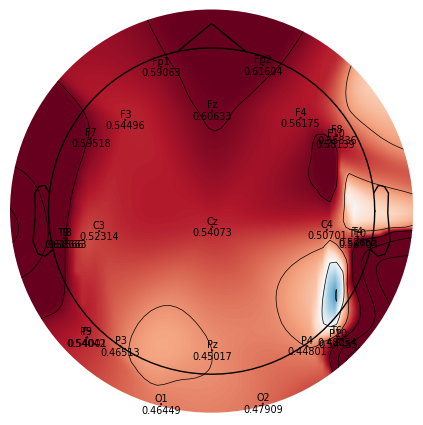

In [130]:
fig, ax = plt.subplots()
im, cn = mne.viz.plot_topomap(hurst_values, pos_array, names=names_hurst,
                              show_names=True, sensors=True, axes=ax,
                              cmap='RdBu_r')


Обработка канала: Fp1


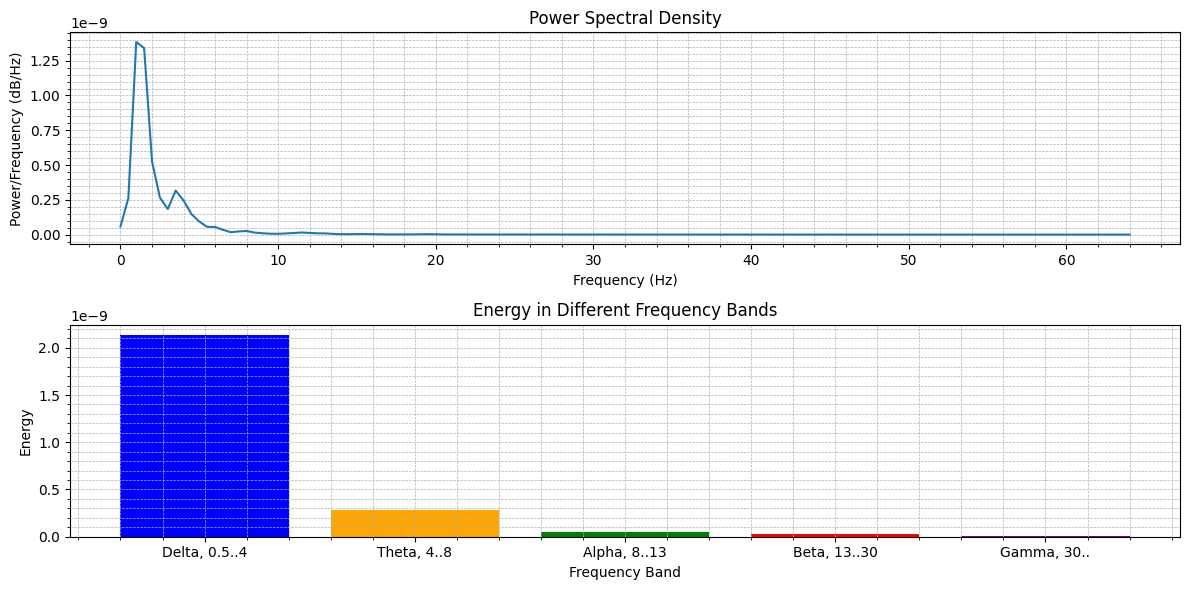

Обработка канала: Fpz


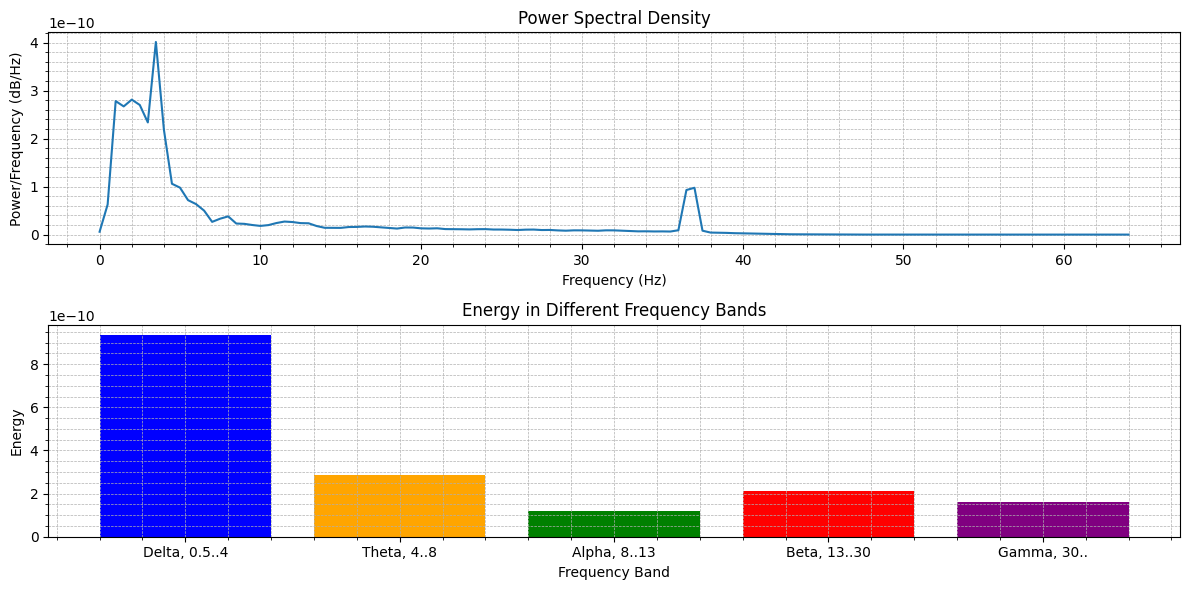

Обработка канала: Fp2


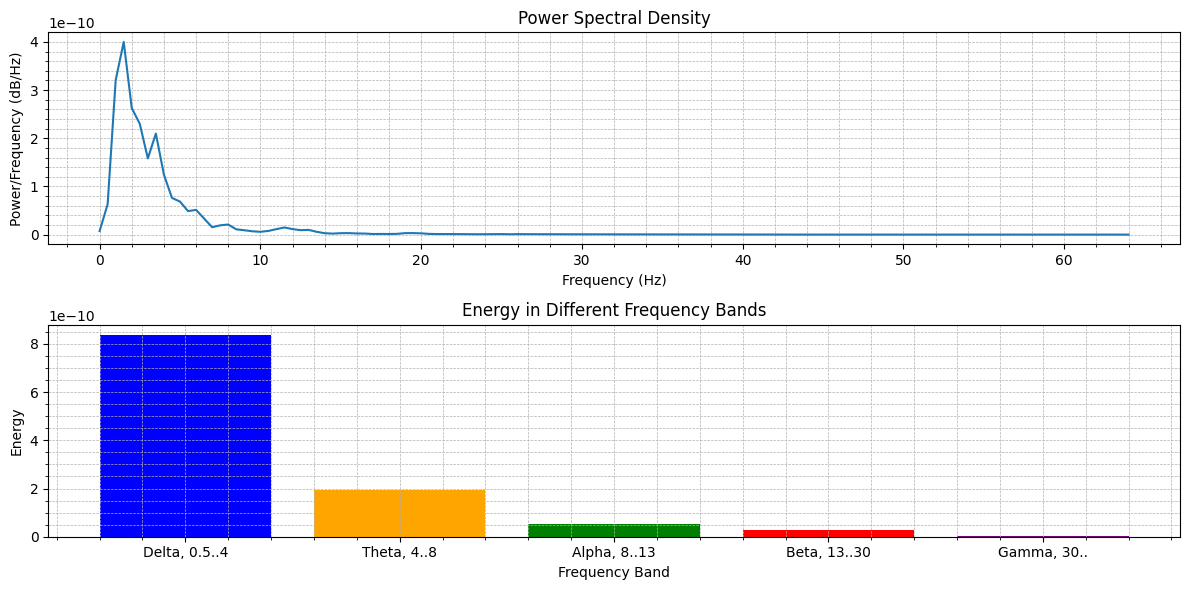

Обработка канала: F7


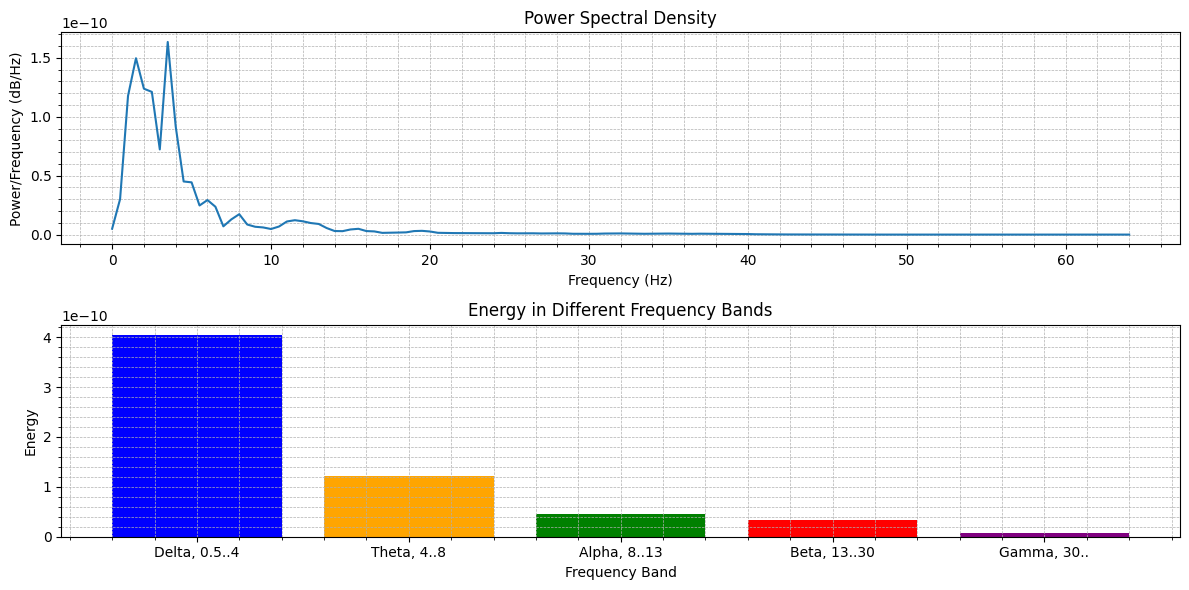

Обработка канала: F3


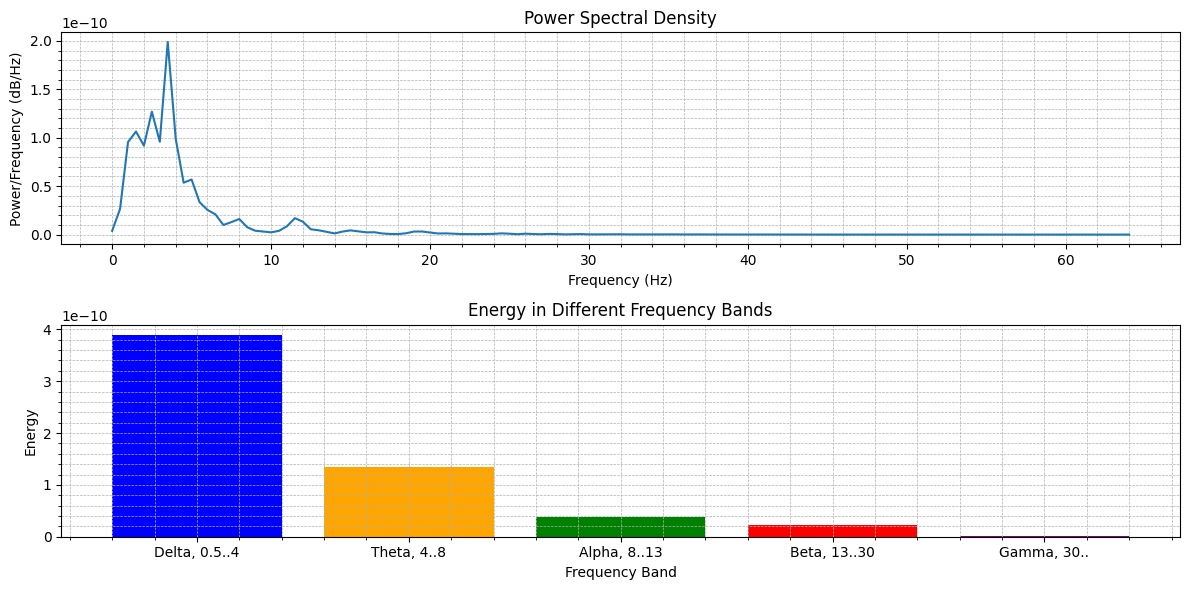

Обработка канала: Fz


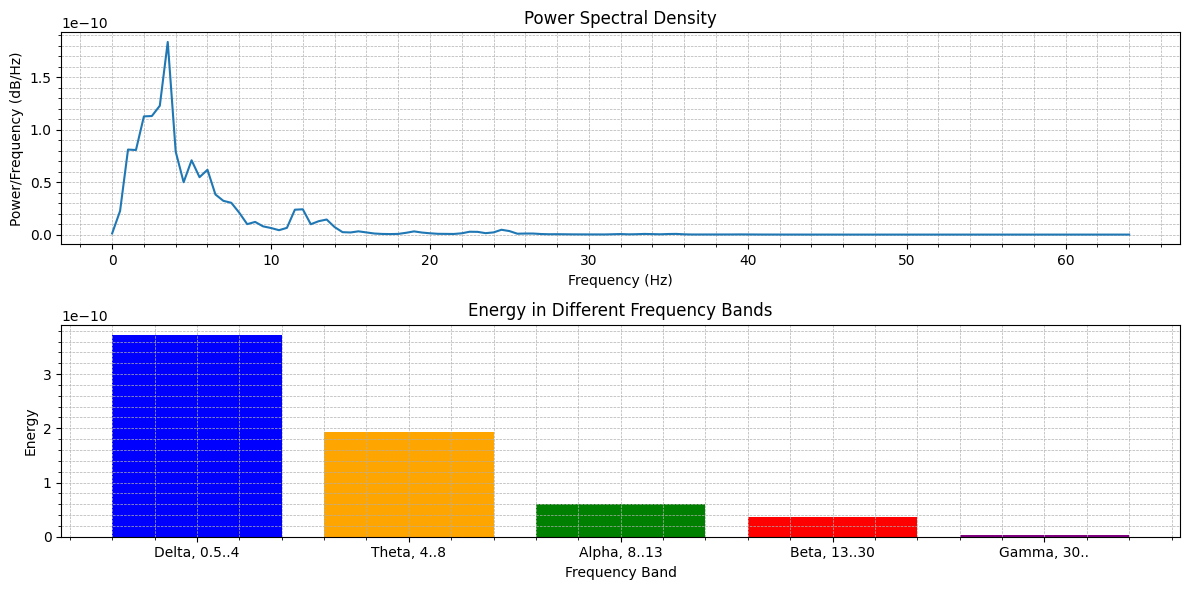

Обработка канала: F4


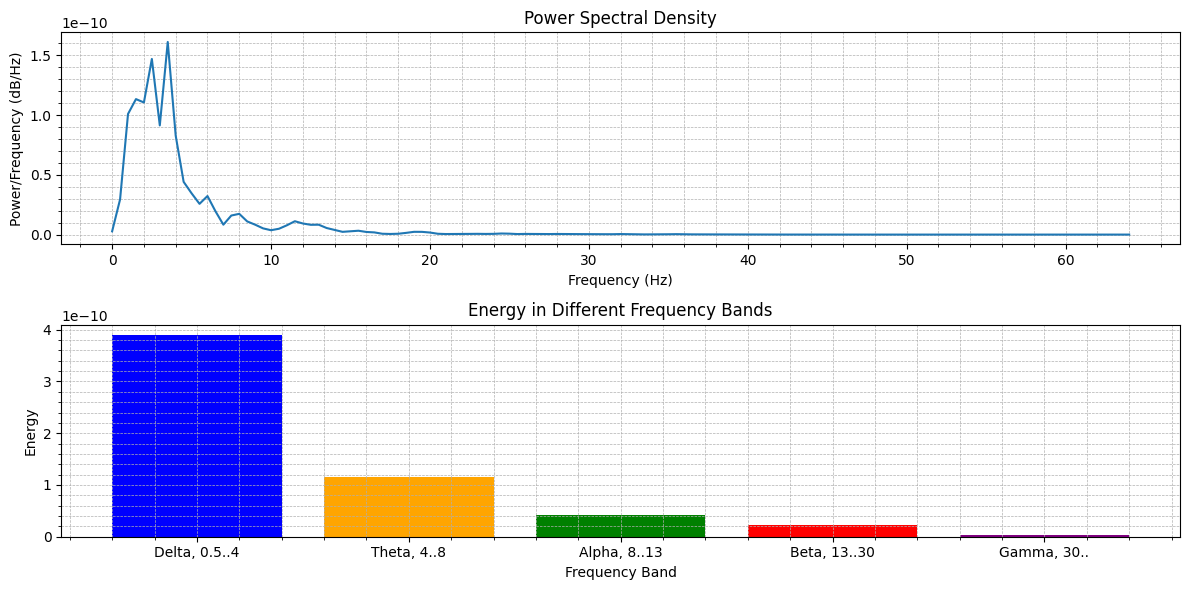

Обработка канала: F8


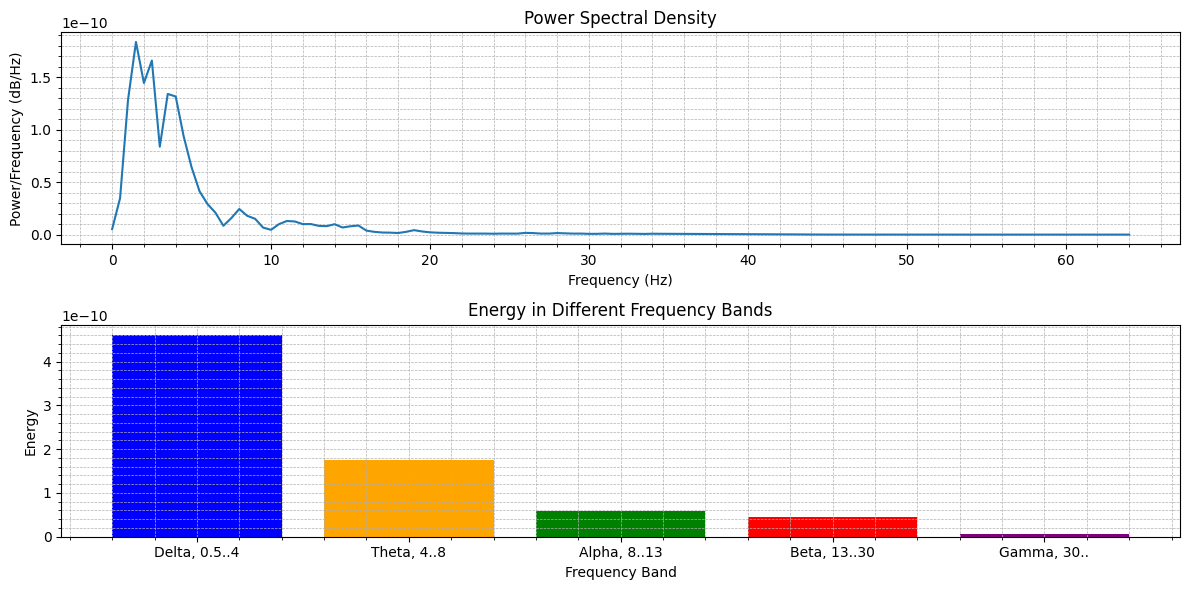

Обработка канала: T3


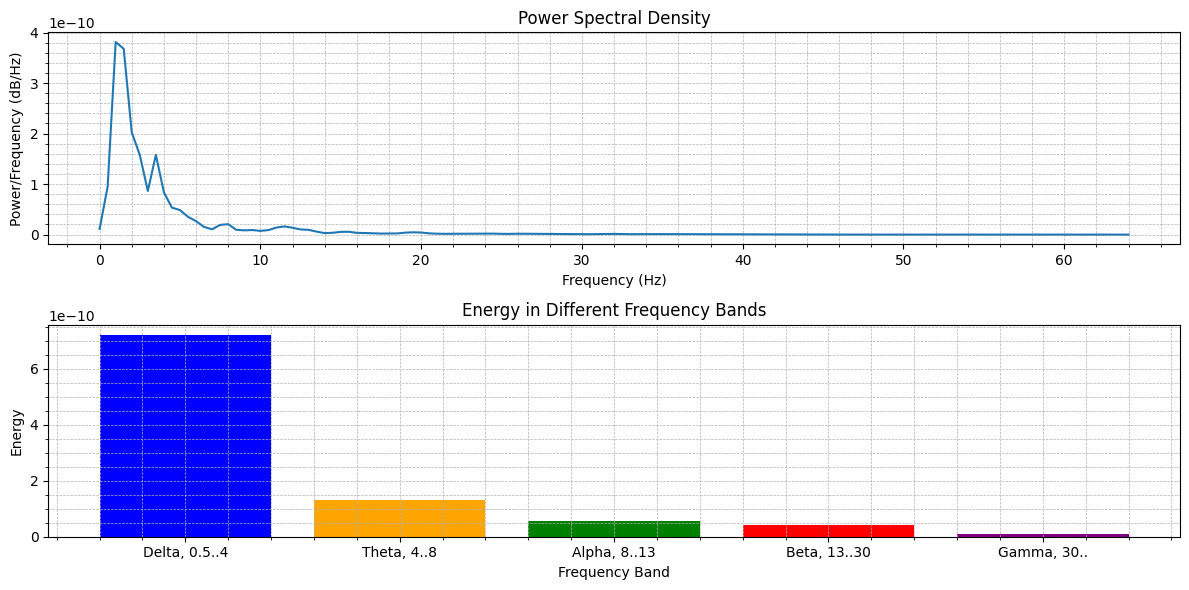

Обработка канала: C3


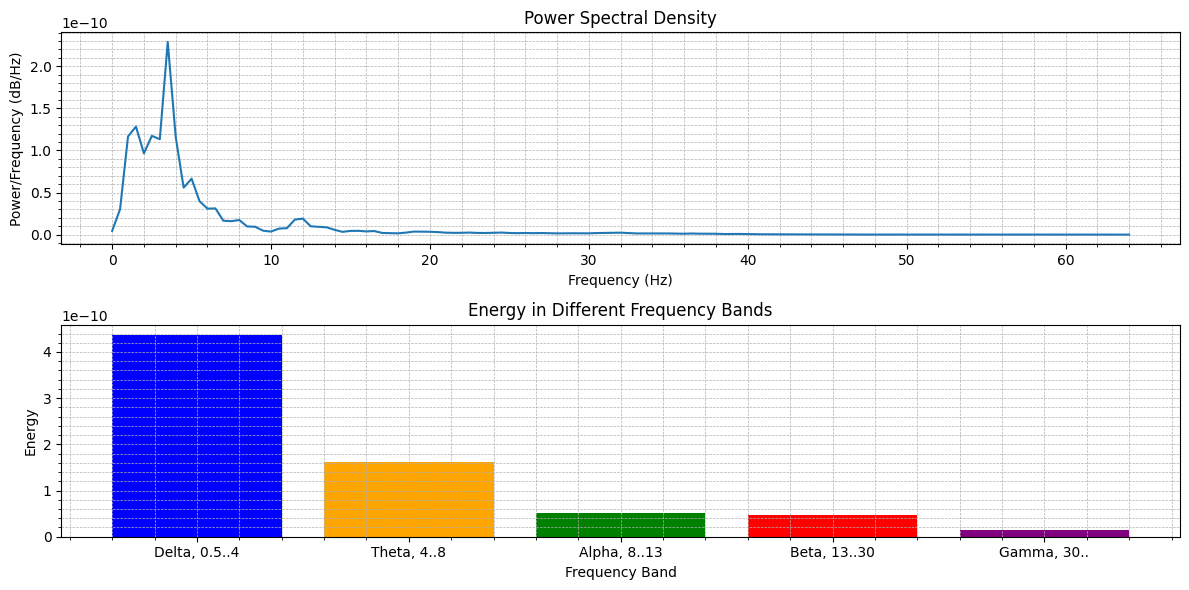

Обработка канала: Cz


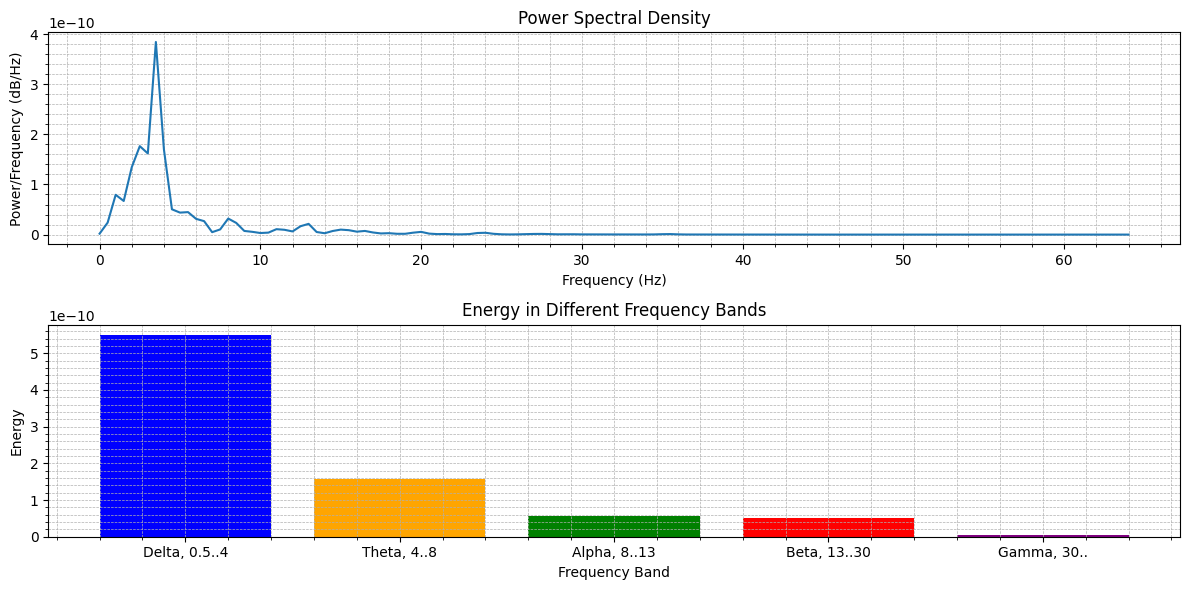

Обработка канала: C4


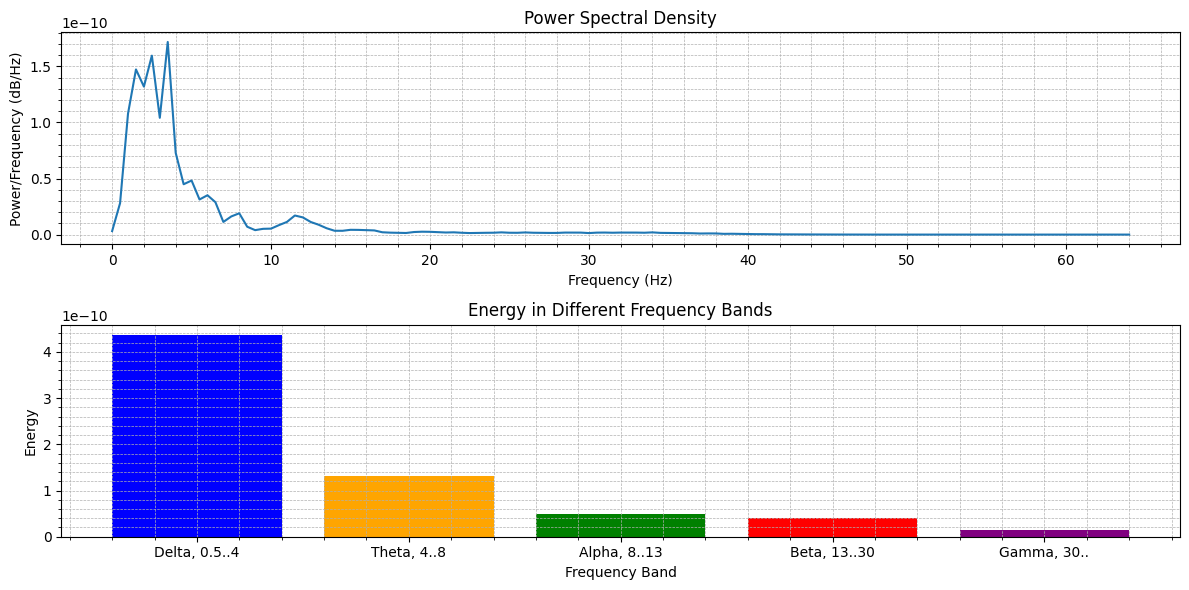

Обработка канала: T4


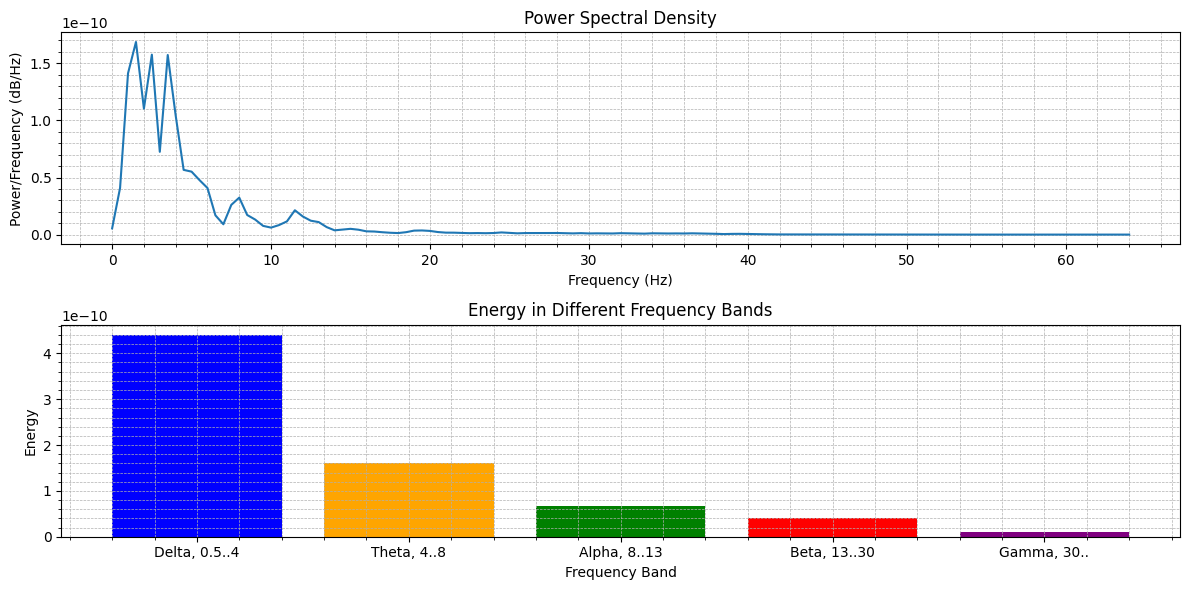

Обработка канала: T5


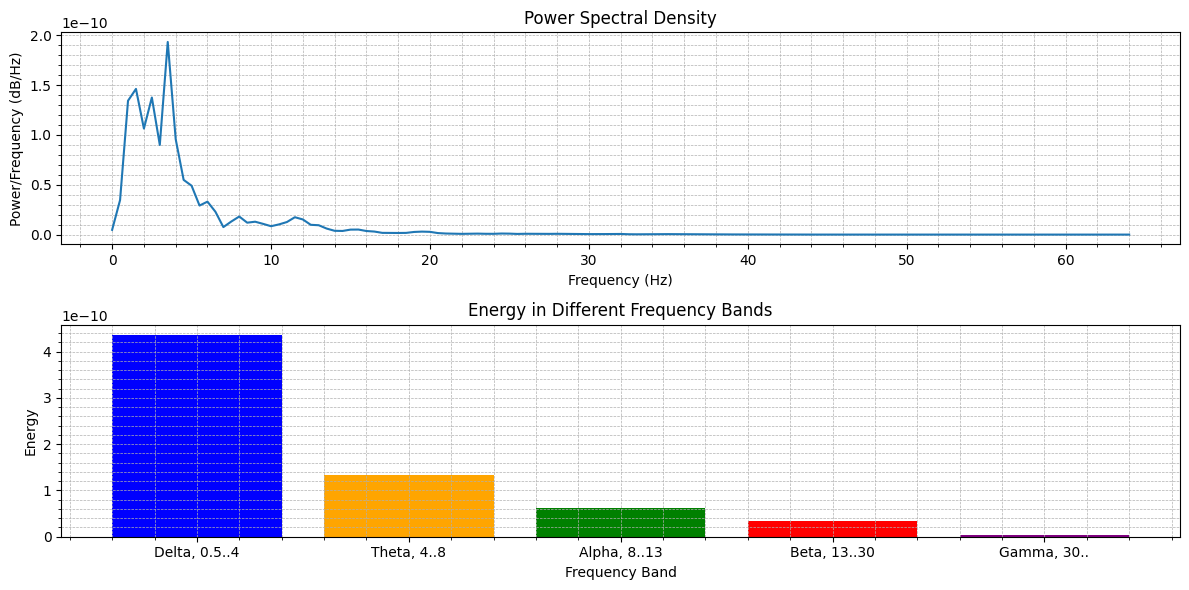

Обработка канала: P3


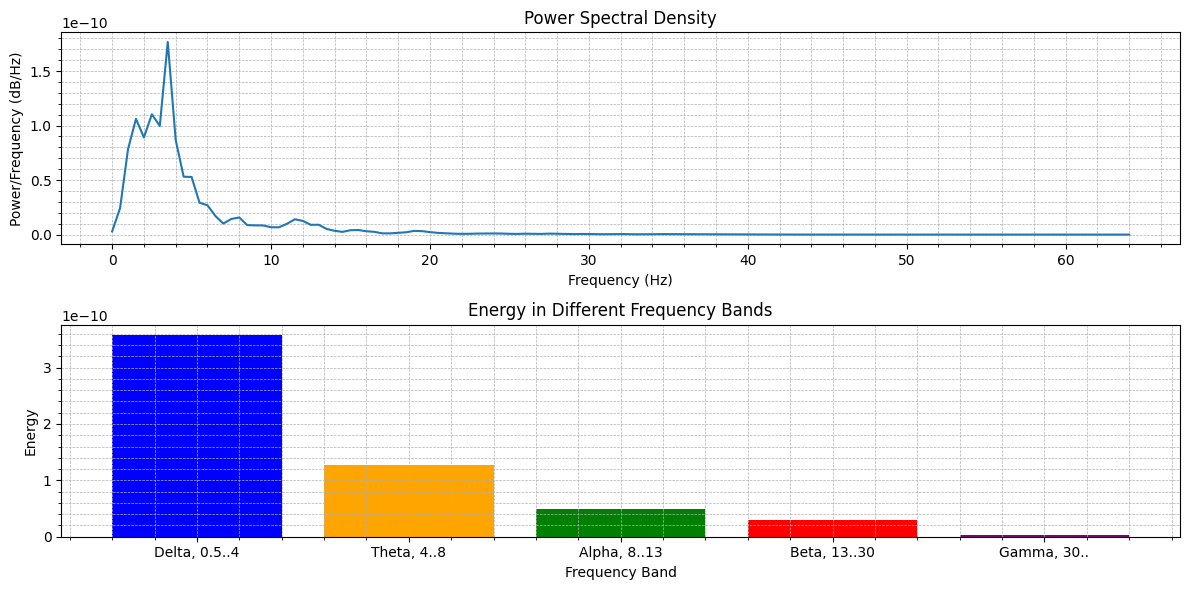

Обработка канала: Pz


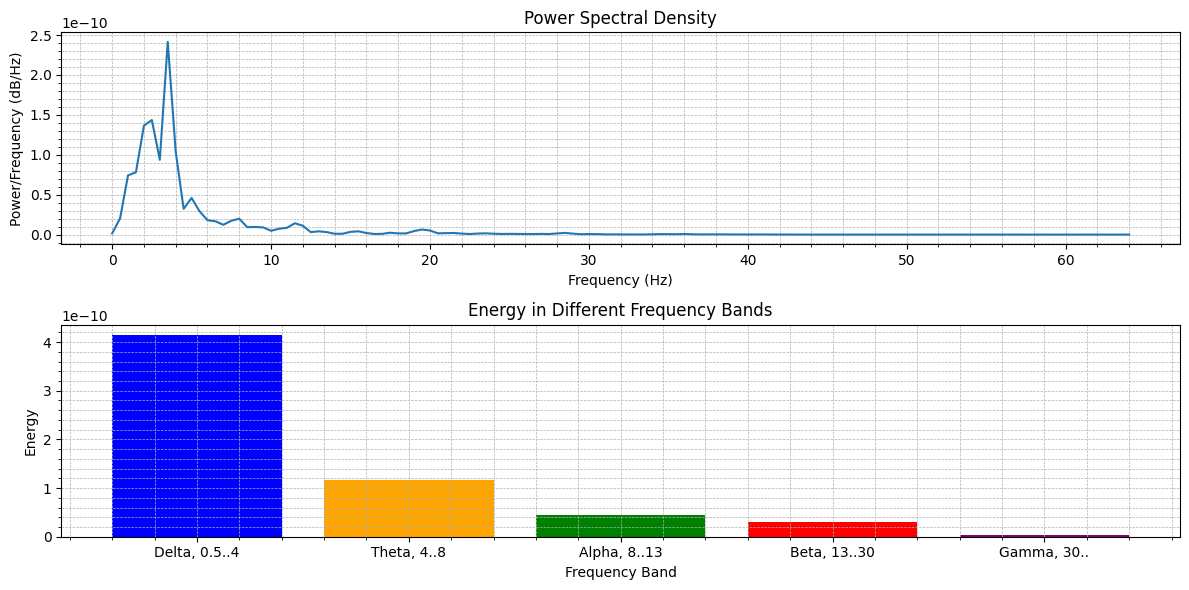

Обработка канала: P4


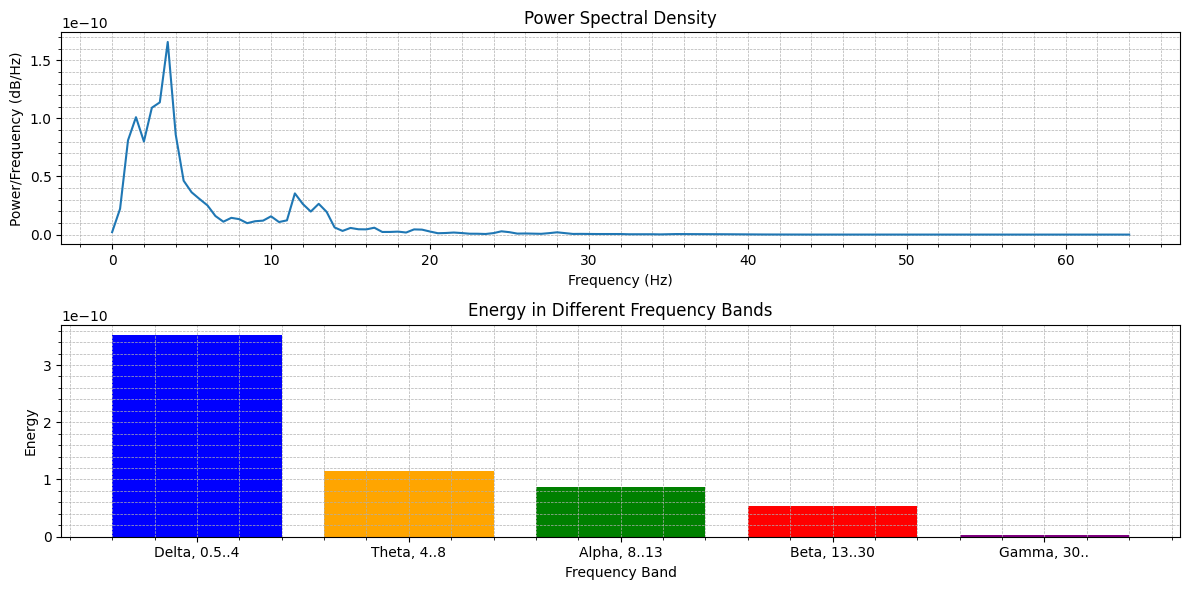

Обработка канала: T6


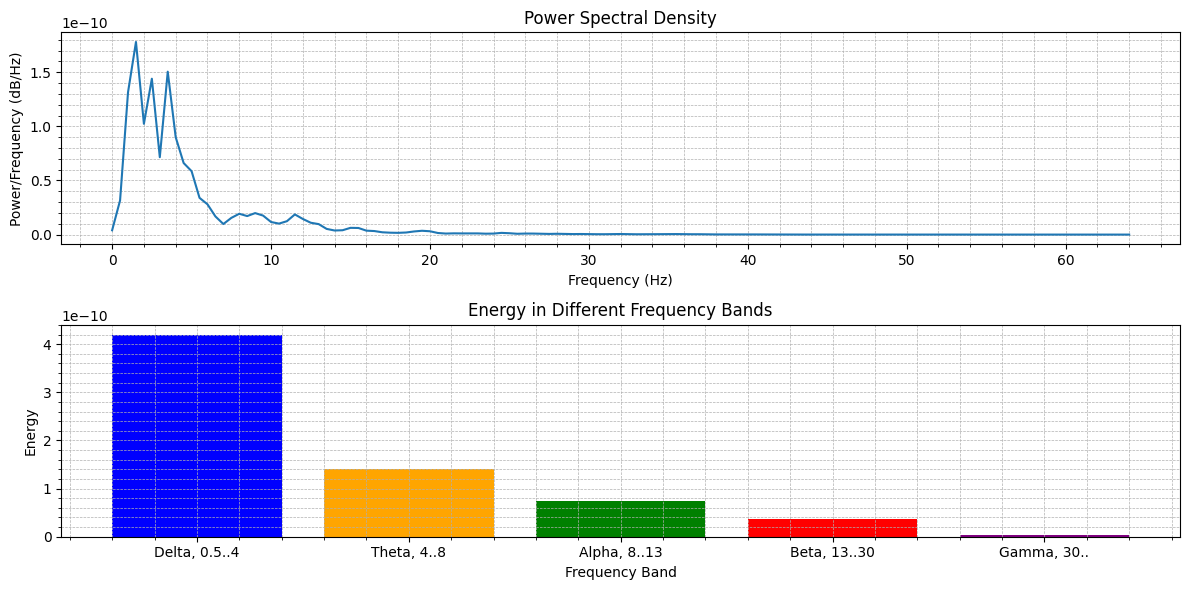

Обработка канала: O1


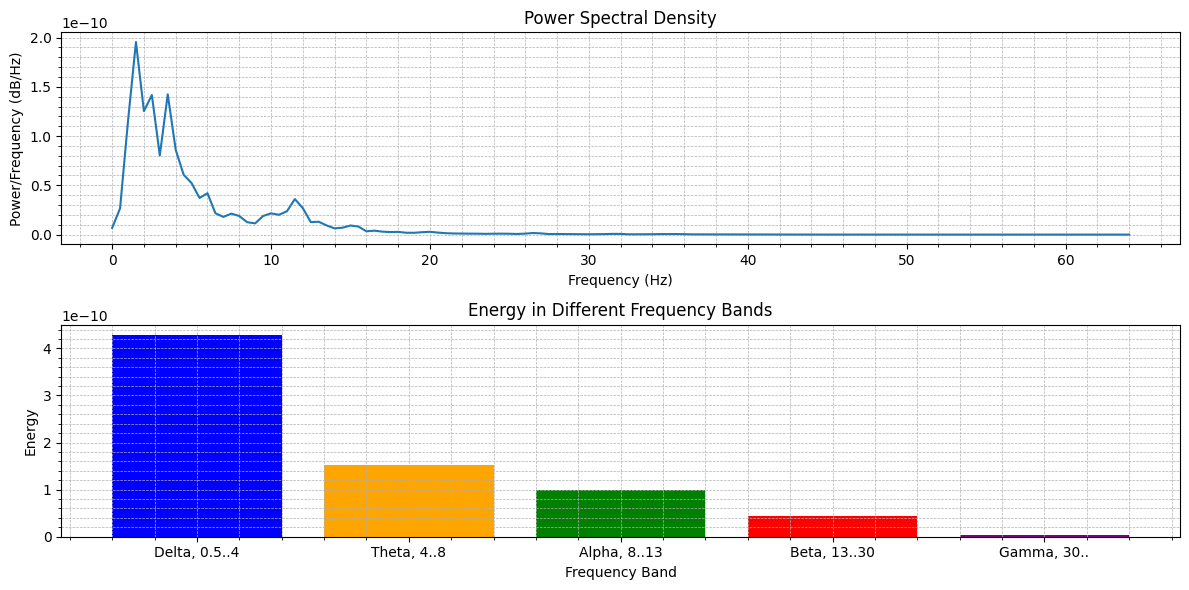

Обработка канала: O2


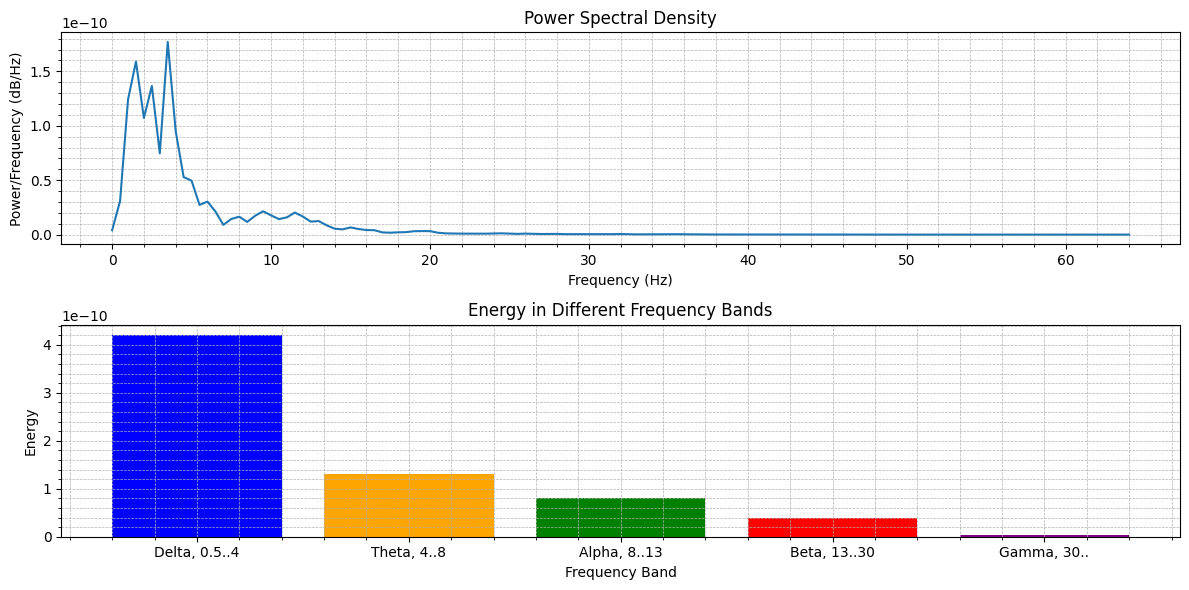

Обработка канала: F9


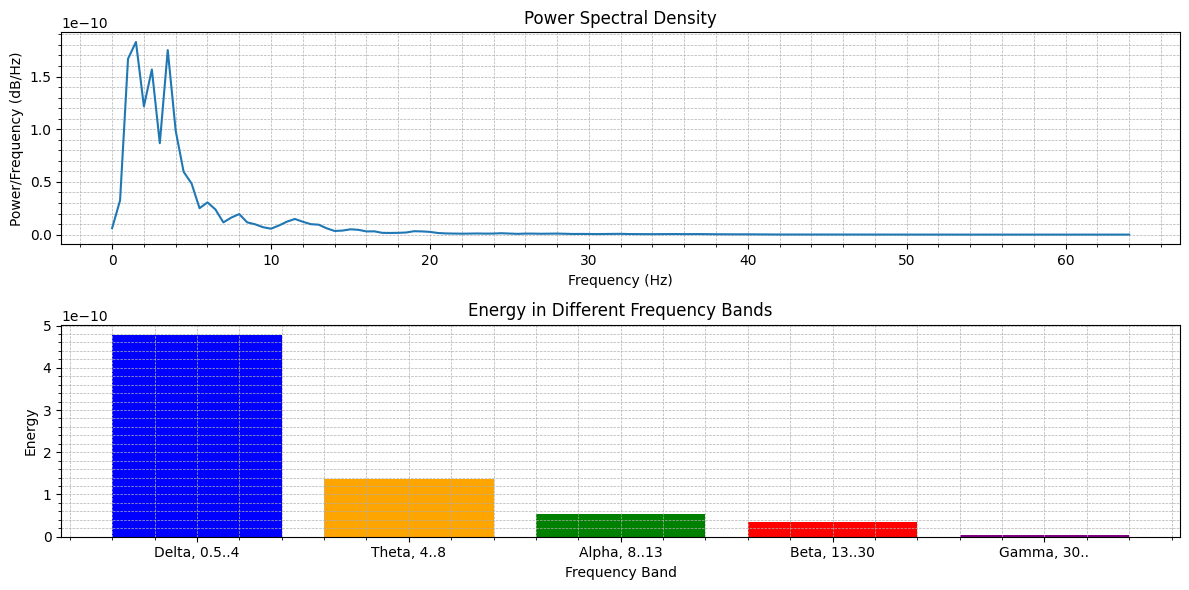

Обработка канала: T9


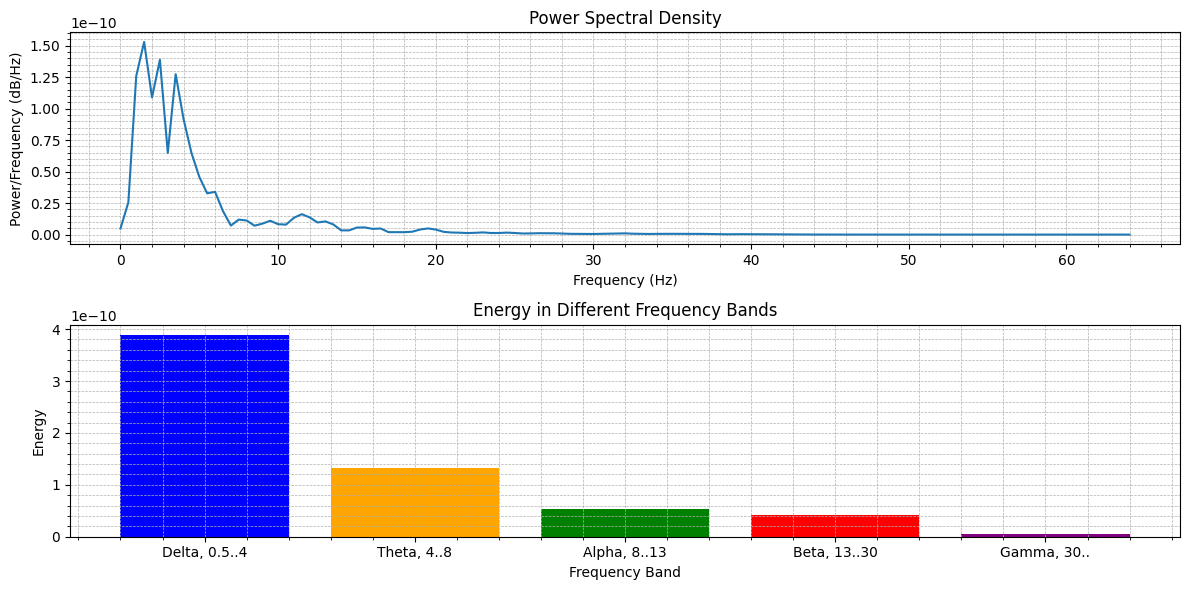

Обработка канала: P9


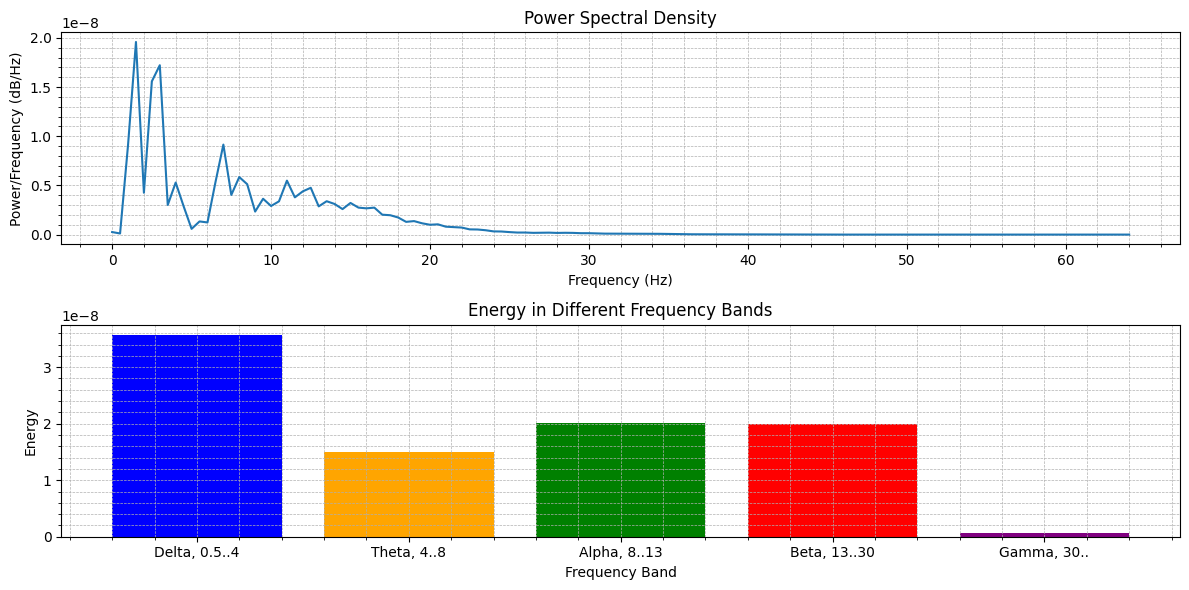

Обработка канала: F10


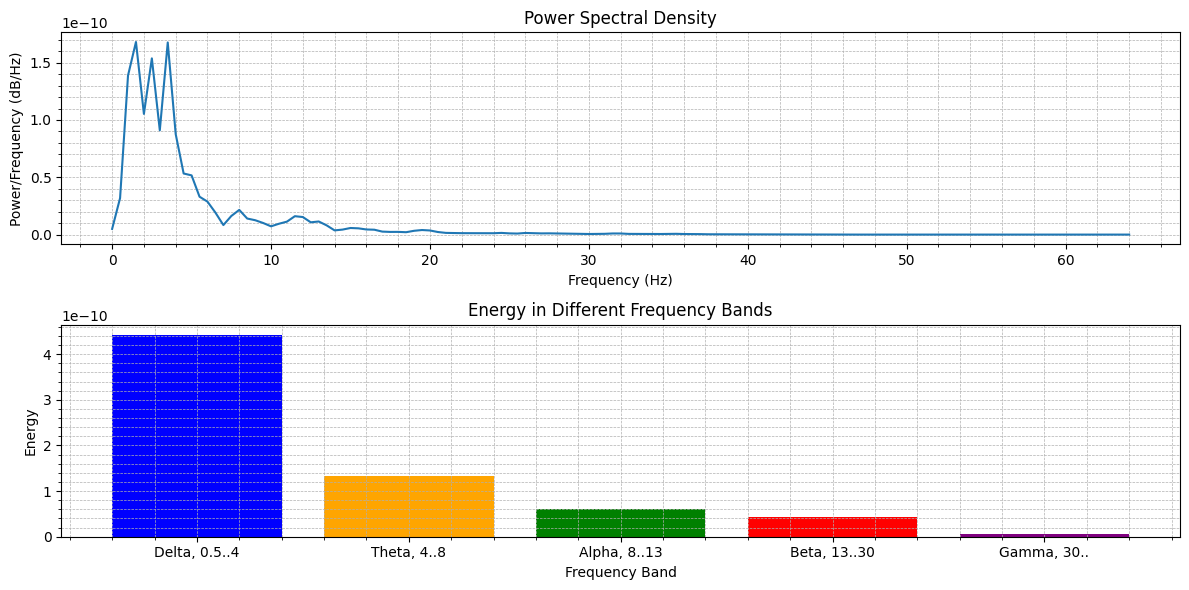

Обработка канала: T10


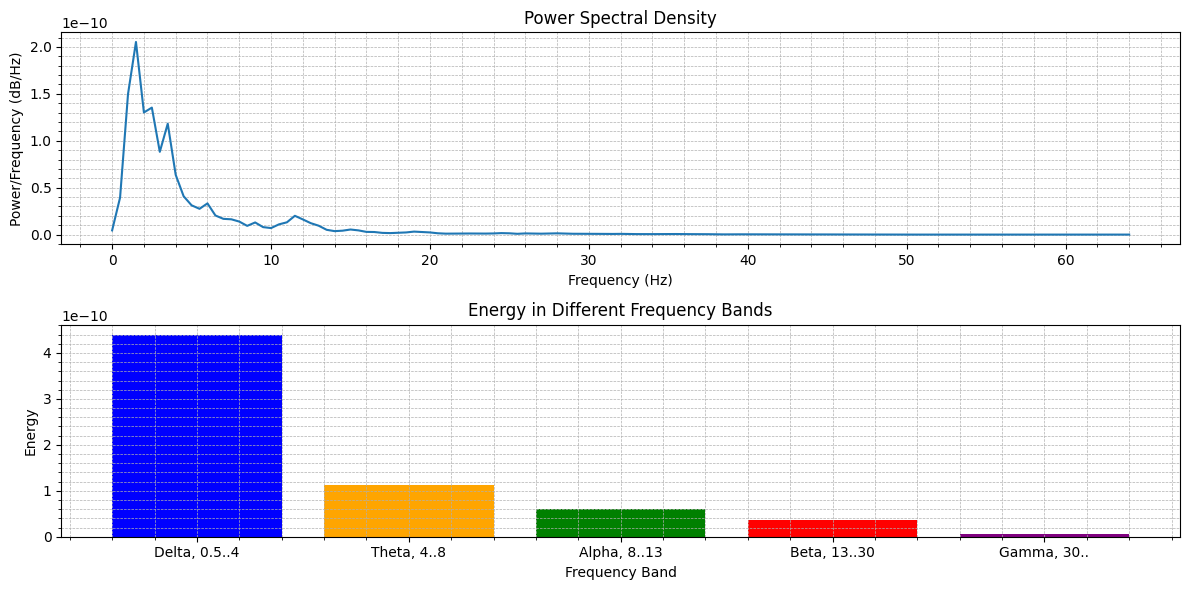

Обработка канала: P10


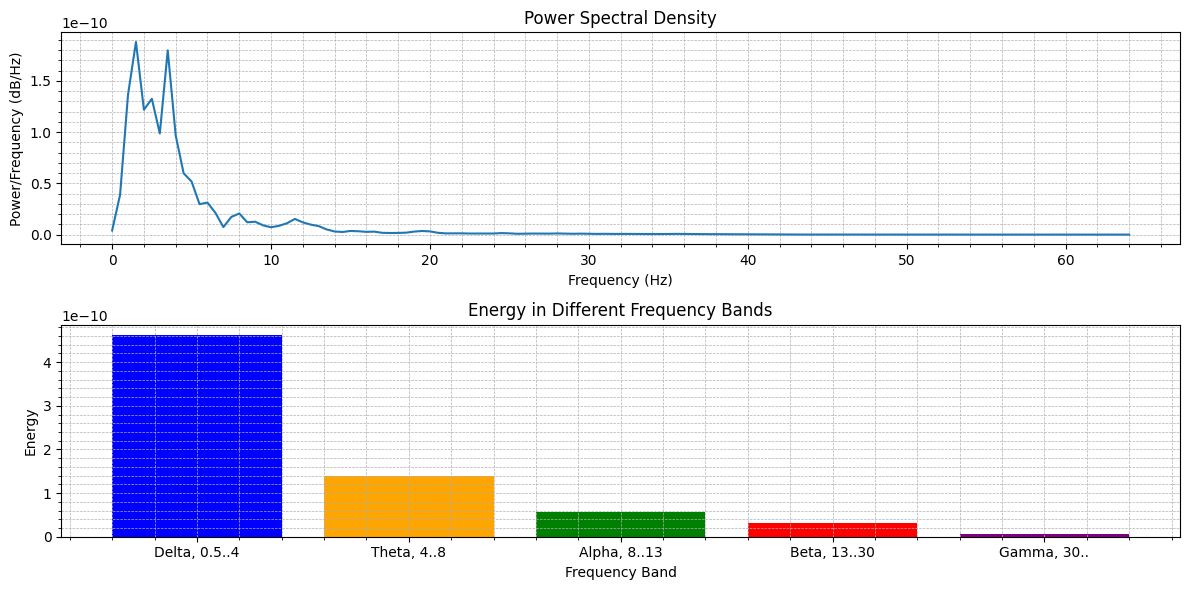

In [81]:
def compute_energy_in_frequency_band(freqs, psd, band):
    indices = np.where((freqs >= band[0]) & (freqs <= band[1]))[0]
    energy = np.trapz(psd[indices], freqs[indices])
    return energy

def plot_spectrogram_and_energy(signal, sample_rate):
    freqs, psd = welch(signal, sample_rate)

    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)
    gamma_band = (30, 100)

    energy_delta = compute_energy_in_frequency_band(freqs, psd, delta_band)
    energy_theta = compute_energy_in_frequency_band(freqs, psd, theta_band)
    energy_alpha = compute_energy_in_frequency_band(freqs, psd, alpha_band)
    energy_beta  = compute_energy_in_frequency_band(freqs, psd, beta_band)
    energy_gamma = compute_energy_in_frequency_band(freqs, psd, gamma_band)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(freqs, psd)
    plt.title('Power Spectral Density')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()

    plt.subplot(2, 1, 2)
    bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    energies = [energy_delta, energy_theta, energy_alpha, energy_beta, energy_gamma]
    plt.bar(bands, energies, color=['blue', 'orange', 'green', 'red', 'purple'])
    plt.title('Energy in Different Frequency Bands')
    plt.xlabel('Frequency Band')
    plt.xticks(np.arange(5), ('Delta, 0.5..4', 'Theta, 4..8', 'Alpha, 8..13', 'Beta, 13..30', 'Gamma, 30..'))
    plt.ylabel('Energy')
    plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()

    plt.tight_layout()
    plt.show()


sample_rate = data_from_raw_edf.info['sfreq']


for channel_index, channel_name in enumerate(names):
    print(f"Обработка канала: {channel_name}")
    signal = eeg_data[channel_index]
    plot_spectrogram_and_energy(signal, sample_rate)

In [131]:
c_index = channel_names.index(channel_names[0])
c_signal = eeg_data[c_index]
fs = data_from_raw_edf.info['sfreq']
lowcut = 1
highcut = 40

In [132]:
# delta_t = 450
# delta_t = 900
delta_t = 18
window_size = int(delta_t * fs)
windows = [c_signal[i:i + window_size] for i in range(0, len(c_signal), window_size) if len(c_signal[i:i + window_size]) == window_size]
hurst_exponents_windowed = []

In [133]:
for window_index, window in enumerate(windows):
  lag = np.unique(np.logspace(0.5, 3, 100, dtype=int))
  q = 2
  order = 1

  try:
      lag, dfa = MFDFA(window, lag=lag, q=q, order=order)
      del_nan = np.argwhere(np.isnan(dfa))
      dfa = np.delete(dfa, del_nan[:,0])
      lag = np.delete(lag, del_nan[:,0])
      H_hat, C_hat = np.polyfit(np.log10(lag)[0:-1], np.log10(dfa[0:-1]), 1)
      hurst_exponents_windowed.append((window_index + 1, H_hat))
  except Exception as e:
      print(f"Ошибка при обработке окна {window_index + 1}: {e}")
      hurst_exponents_windowed.append((window_index + 1, np.nan))

In [134]:
hurst_df_windowed = pd.DataFrame(hurst_exponents_windowed, columns=['Номер окна', 'Показатель индекса Херста'])
print(hurst_df_windowed)

   Номер окна  Показатель индекса Херста
0           1                   0.546540
1           2                   0.625100
2           3                   0.590257
3           4                   0.650626
4           5                   0.543625
5           6                   0.518979
6           7                   0.562073
7           8                   0.571772
8           9                   0.527958


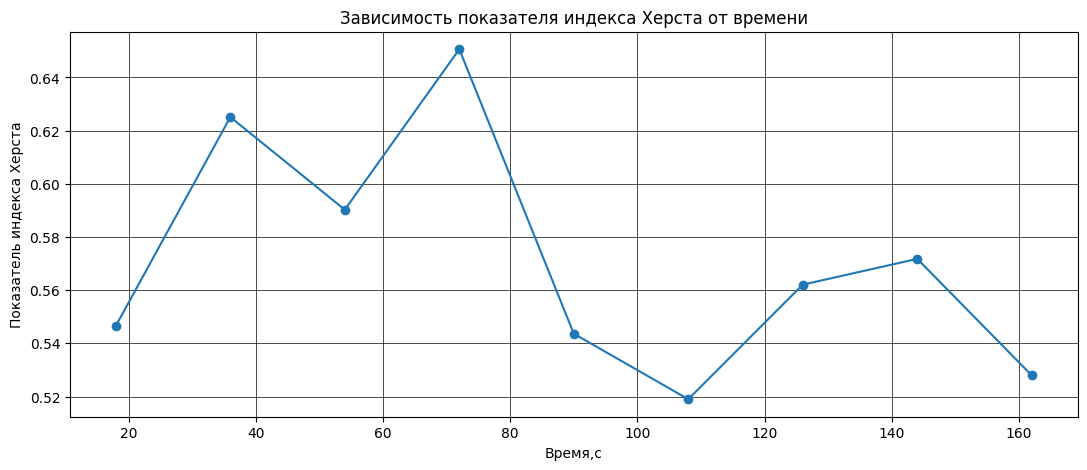

In [135]:
plt.figure(figsize=(13, 5))
times = (np.arange(len(hurst_df_windowed)) + 1) * delta_t
plt.plot(times, hurst_df_windowed['Показатель индекса Херста'], marker='o')

plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.xlabel('Время,с')
plt.ylabel('Показатель индекса Херста')
plt.title('Зависимость показателя индекса Херста от времени')
plt.grid(True)
plt.show()

In [136]:
i = 1
hurst_values = []
window_sizes = []
while True:
    window_size = int(delta_t * i * fs)
    if window_size > len(c_signal):
        break
    window_signal = c_signal[:window_size]
    try:
        lag, dfa = MFDFA(window_signal, lag=lag, q=q, order=order)
        del_nan = np.argwhere(np.isnan(dfa))
        dfa = np.delete(dfa, del_nan[:, 0])
        lag = np.delete(lag, del_nan[:, 0])
        H_hat, _ = np.polyfit(np.log10(lag)[0:-1], np.log10(dfa[0:-1]), 1)
        hurst_values.append(H_hat)
        window_sizes.append(window_size / fs)
    except Exception as e:
        print(f"Ошибка при обработке окна {i}: {e}")
        hurst_values.append(np.nan)
    i += 1
window_numbers = list(range(1, len(hurst_values) + 1))
results_df = pd.DataFrame({
    'Номер окна': window_numbers,
    'Показатель индекса Херста': hurst_values
})

print(results_df)

   Номер окна  Показатель индекса Херста
0           1                   0.546540
1           2                   0.614173
2           3                   0.604072
3           4                   0.630539
4           5                   0.618518
5           6                   0.606000
6           7                   0.600721
7           8                   0.597553
8           9                   0.590957


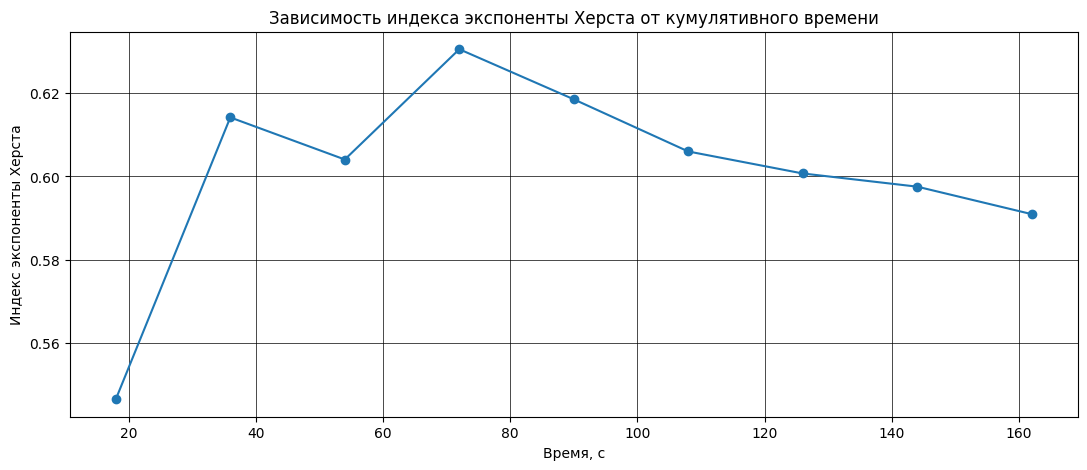

In [137]:
plt.figure(figsize=(13, 5))
plt.plot(window_sizes, hurst_values, marker='o')

plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.xlabel('Время, с')
plt.ylabel('Индекс экспоненты Херста')
plt.title('Зависимость индекса экспоненты Херста от кумулятивного времени')
plt.grid(True)
plt.show()